# Project Name: Lending Club Case Study

Team : Harsh Kumar Dewangan & Sarvjeet Luthra

Date : 20-05-2024

# Business Understanding

1. Lending Club is a finance company that specializes in lending to urban customers.
2. When receiving a loan application, the decision to approve hinges on the applicant's profile.
3. The bank faces two risk scenarios in the decision-making process:
    1. If the applicant is expected to repay, denying the loan results in lost business for the company.
    2. If the applicant is likely to default, approving the loan could lead to financial loss for the company.


# Objective

Find the driving factors which lead to the defaulted loans which are major source of loss for the company.


## Import the necessary libraries

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.core.display import HTML
%matplotlib inline
warnings.filterwarnings('ignore') # if there are any warning due to version mismatch, it will be ignored

In [3]:
# importing the dataset
data = pd.read_csv('/content/drive/MyDrive/Upgrad Case Study Loan Dataset/loan.csv')

In [4]:
#data exploration
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [6]:
# the rows and columns in data
data.shape

(39717, 111)

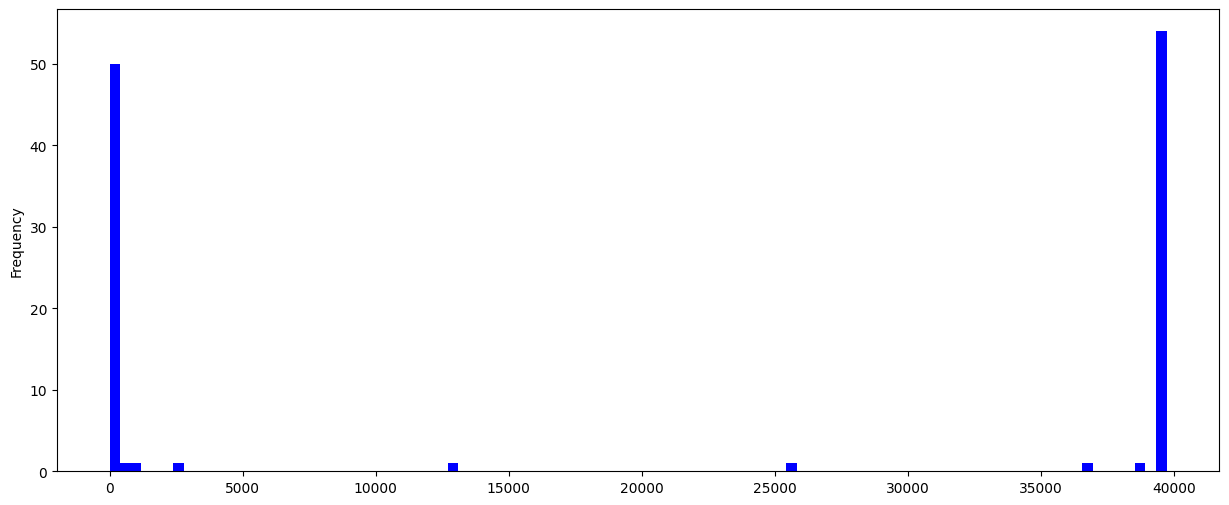

In [7]:
# as we see some columns have missing values and unique values, let see explore more to keep or drop them
# removing null values
missing_values = data.isnull().sum()
missing_values.plot(kind='hist', bins=100, color="blue", figsize = (15,6))
plt.show()

### There are lot of features which contains null values more than 10000.

In [8]:
missing_values.loc[(missing_values.values > 10000) & (missing_values.values < 39717)].sort_values()

desc                      12942
mths_since_last_delinq    25682
mths_since_last_record    36931
next_pymnt_d              38577
dtype: int64

### Dropping all the columns with null values above 10K.

In [9]:
data.drop(columns=list(missing_values[missing_values.values > 10000].index), inplace=True)
data.shape

(39717, 53)

In [10]:
r = data.isnull().sum(axis=1)*100 / len(data.columns)
max(r.values)

9.433962264150944

Let us see if there are any columns with unique or single values in them.

In [11]:
unique_cols = data.nunique()
print(unique_cols)

id                            39717
member_id                     39717
loan_amnt                       885
funded_amnt                    1041
funded_amnt_inv                8205
term                              2
int_rate                        371
installment                   15383
grade                             7
sub_grade                        35
emp_title                     28820
emp_length                       11
home_ownership                    5
annual_inc                     5318
verification_status               3
issue_d                          55
loan_status                       3
pymnt_plan                        1
url                           39717
purpose                          14
title                         19615
zip_code                        823
addr_state                       50
dti                            2868
delinq_2yrs                      11
earliest_cr_line                526
inq_last_6mths                    9
open_acc                    

### Checking columns for irrelevant data which has no impact to analysis(having single unique values)

In [12]:
u = unique_cols[unique_cols.values == 1]
u.index

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

In [13]:
# dropping the columns
data.drop(columns = list(u.index), inplace=True)
data.shape

(39717, 44)

#### The company wants to know which loan applications are risky. Therefore, the fields that are created after a loan application is approved doesn't make sense for our analysis towards the business objective. Secondly, fields like id, member_id & url are different for each application. zip_code could have been a useful driver, but it contains only partial data which might impute our analysis negatively. Therefore, let us drop all these columns mentioned below

In [14]:
del_cols = ["id","member_id","url","zip_code","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",
            "total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee",
            "last_pymnt_d","last_pymnt_amnt","last_credit_pull_d"]
data.drop(columns=del_cols, inplace=True)
data.shape

(39717, 28)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39717 non-null  int64  
 1   funded_amnt           39717 non-null  int64  
 2   funded_amnt_inv       39717 non-null  float64
 3   term                  39717 non-null  object 
 4   int_rate              39717 non-null  object 
 5   installment           39717 non-null  float64
 6   grade                 39717 non-null  object 
 7   sub_grade             39717 non-null  object 
 8   emp_title             37258 non-null  object 
 9   emp_length            38642 non-null  object 
 10  home_ownership        39717 non-null  object 
 11  annual_inc            39717 non-null  float64
 12  verification_status   39717 non-null  object 
 13  issue_d               39717 non-null  object 
 14  loan_status           39717 non-null  object 
 15  purpose            

In [16]:
data.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,pub_rec_bankruptcies
count,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39020.000000
mean,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,9.294408,0.055065,13382.528086,22.088828,0.043260
std,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,4.400282,0.237200,15885.016641,11.401709,0.204324
min,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000
25%,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,6.000000,0.000000,3703.000000,13.000000,0.000000
50%,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,9.000000,0.000000,8850.000000,20.000000,0.000000
75%,15000.000000,15000.000000,14400.000000,430.780000,8.230000e+04,18.600000,0.000000,1.000000,12.000000,0.000000,17058.000000,29.000000,0.000000
max,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,90.000000,2.000000


### Data preparation

In [17]:
data['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64

In [18]:
# here "Current" will not be helpful for our analysis, so removing those
# data = data[~(data['loan_status'] == 'Current')]
data = data[data['loan_status'] != 'Current']
data.shape

(38577, 28)

In [19]:
data['term'].value_counts()

term
 36 months    29096
 60 months     9481
Name: count, dtype: int64

In [20]:
data['int_rate'].head()

0    10.65%
1    15.27%
2    15.96%
3    13.49%
5     7.90%
Name: int_rate, dtype: object

In [21]:
#We need only numerical part for analysis, thus removing %
data['int_rate'] = data['int_rate'].apply(lambda x: pd.to_numeric(x.split("%")[0]))
data['int_rate'].describe()

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64

<Axes: >

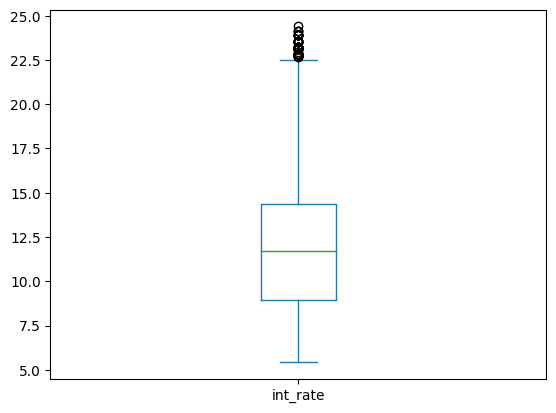

In [22]:
data['int_rate'].plot.box()

#### When conducting univariate analysis, it's important to examine the outlier values present in the 'int_rate' column.

In [23]:
data['grade'].value_counts()

grade
B    11675
A    10045
C     7834
D     5085
E     2663
F      976
G      299
Name: count, dtype: int64

In [24]:
data['sub_grade'].value_counts()

sub_grade
A4    2873
B3    2825
A5    2715
B5    2615
B4    2437
C1    2055
B2    2001
C2    1931
A3    1810
B1    1797
A2    1508
C3    1488
D2    1286
C4    1206
C5    1154
A1    1139
D3    1116
D1     931
D4     918
D5     834
E1     722
E2     614
E3     516
E4     424
E5     387
F1     305
F2     233
F3     174
F4     151
F5     113
G1      94
G2      77
G4      54
G3      45
G5      29
Name: count, dtype: int64

In [25]:
print(data['emp_title'].value_counts().head())
print(data['emp_title'].unique().shape)

emp_title
US Army              131
Bank of America      107
IBM                   65
AT&T                  57
Kaiser Permanente     56
Name: count, dtype: int64
(28028,)


In [26]:
data['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '1 year', '6 years', '2 years', '7 years',
       nan], dtype=object)

In [27]:
data['emp_length'].isnull().sum()

1033

In [28]:
data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'pub_rec_bankruptcies'],
      dtype='object')

In [29]:
data['home_ownership'].value_counts()

home_ownership
RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: count, dtype: int64

In [30]:
data['verification_status'].value_counts()

verification_status
Not Verified       16694
Verified           12206
Source Verified     9677
Name: count, dtype: int64

In [31]:
data['issue_d'].head()

0    Dec-11
1    Dec-11
2    Dec-11
3    Dec-11
5    Dec-11
Name: issue_d, dtype: object

In [32]:
# splitting month and year
data["issue_d"]=pd.to_datetime(data["issue_d"],format='%b-%y')
y = pd.to_datetime(data["issue_d"],format='%b-%y').dt.year
m = pd.to_datetime(data["issue_d"],format='%b-%y').dt.month

In [33]:
y.value_counts()

issue_d
2011    20516
2010    11532
2009     4716
2008     1562
2007      251
Name: count, dtype: int64

In [34]:
m.value_counts()

issue_d
12    4215
11    4006
10    3761
9     3498
8     3388
7     3351
6     3180
5     2919
4     2831
3     2691
1     2379
2     2358
Name: count, dtype: int64

#### let us add new column like issued_year and issued_month which will be useful for our further analysis and drop this issue_d column


In [35]:
data['issue_y'] = pd.to_numeric(y)
data['issue_m'] = m
data.drop(columns=['issue_d'], inplace=True)

In [36]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,Jan-85,1,3,0,13648,83.70%,9,0.0,2011,12
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,Apr-99,5,3,0,1687,9.40%,4,0.0,2011,12
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,Nov-01,2,2,0,2956,98.50%,10,0.0,2011,12
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,Feb-96,1,10,0,5598,21%,37,0.0,2011,12
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,Nov-04,3,9,0,7963,28.30%,12,0.0,2011,12


In [37]:
data['purpose'].value_counts()

purpose
debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: count, dtype: int64

In [38]:
len(data['title'].value_counts())

19297

In [39]:
data['title'].head(10)

0                                  Computer
1                                      bike
2                      real estate business
3                                  personel
5     My wedding loan I promise to pay back
6                                      Loan
7                           Car Downpayment
8      Expand Business & Buy Debt Portfolio
9               Building my credit history.
10               High intrest Consolidation
Name: title, dtype: object

In [40]:
data['title'].sample(10)

20417                                  Wedding
10380                       Debt Consolidation
22887                         home improvement
24483                         home improvments
16414                                DEBTS PIF
21696    Consolidate debt single fixed payment
17785                1st reliable car purchase
39427                          Loan Investment
25715                                 Car Loan
8390                                  New Roof
Name: title, dtype: object

In [41]:
# there are too many unique values in title thus it will not be so helpful to understand any trend
# dropping the column
data.drop(columns=['title'], inplace=True)

In [42]:
data['addr_state'].value_counts()

addr_state
CA    6949
NY    3698
FL    2781
TX    2659
NJ    1790
IL    1478
PA    1468
VA    1369
GA    1359
MA    1297
OH    1178
MD    1023
AZ     849
WA     818
CO     766
NC     750
CT     726
MI     704
MO     670
MN     605
NV     479
SC     459
WI     440
AL     435
OR     435
LA     427
KY     311
OK     287
KS     255
UT     252
AR     235
DC     211
RI     194
NM     183
WV     172
NH     166
HI     166
DE     113
MT      83
WY      80
AK      78
SD      62
VT      53
MS      19
TN      17
IN       9
ID       6
IA       5
NE       5
ME       3
Name: count, dtype: int64

In [43]:
data['earliest_cr_line'].value_counts()

earliest_cr_line
Oct-99    360
Nov-98    357
Oct-00    341
Dec-98    340
Dec-97    318
         ... 
Nov-65      1
Feb-73      1
Oct-08      1
Dec-61      1
Oct-74      1
Name: count, Length: 524, dtype: int64

In [44]:
data['earliest_cr_line'].str.split(" ", n=1, expand=True)

,0
0,Jan-85
1,Apr-99
2,Nov-01
3,Feb-96
5,Nov-04
...,...
39712,Nov-90
39713,Dec-86
39714,Oct-98
39715,Nov-88


In [45]:
data["earliest_cr_line"]=pd.to_datetime(data["earliest_cr_line"],format='%b-%y')
y = pd.to_datetime(data["earliest_cr_line"],format='%b-%y').dt.year
m = pd.to_datetime(data["earliest_cr_line"],format='%b-%y').dt.month
y.value_counts()

earliest_cr_line
2000    3160
1999    2896
1998    2773
2001    2462
1997    2387
1996    2202
1995    2078
1994    1948
2002    1890
2003    1813
2004    1727
2005    1467
1993    1460
2006    1154
1992    1029
1990    1005
1991     945
1989     834
1988     709
2007     698
1987     590
1986     478
1985     439
1984     395
1983     322
1982     215
1981     181
1980     175
1978     161
1979     157
2008     153
1977     112
1976      93
1975      83
1974      62
1973      61
1972      49
1970      47
1971      45
1969      37
2068      19
2067      18
2066      11
2063      10
2065       8
2064       6
2062       5
2054       2
2061       2
2059       1
2056       1
2046       1
2050       1
Name: count, dtype: int64

In [46]:
# In the 'earliest_cr_line' field, we've noticed inconsistencies in data formatting.
# Occasionally, it's presented as MMM-YY, while other times it's YY-MMM.
# Additionally, the year appears in a two-digit format without Y2K correction. Thus, we'll need to employ logic to extract meaningful data from this field.
from datetime import datetime
today = datetime.today()
today.year

2024

In [47]:
def couting_days_from_earliest_cr_line(d):
    d = datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S')
    d = str(d)
    d = d.split(" ")[0]
    m, y = d.split("-")[1], d.split("-")[0][2:]

    # if y in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']:
    #     y, m = d.split('-')
    y = 2000 + int(y)
    if y > today.year:
        y -= 100
    earliest_cr_line = datetime.strptime(str(y)+'-'+m+'-1', '%Y-%m-%d')
    return (today - earliest_cr_line).days

# couting_days_from_earliest_cr_line("1985-01-01 00:00:00")

In [48]:
data['couting_days_from_earliest_cr_line'] = data['earliest_cr_line'].apply(couting_days_from_earliest_cr_line)
data['couting_days_from_earliest_cr_line'].describe()

count    38577.000000
mean      9967.981647
std       2491.854695
min       5680.000000
25%       8298.000000
50%       9517.000000
75%      11129.000000
max      28630.000000
Name: couting_days_from_earliest_cr_line, dtype: float64

In [49]:
# now we can drop earliest_cr_line
data.drop(columns=['earliest_cr_line'], inplace=True)

In [50]:
data['revol_util'].head()

0    83.70%
1     9.40%
2    98.50%
3       21%
5    28.30%
Name: revol_util, dtype: object

In [51]:
#let us convert these values in numberics by removing %
data['revol_util'] = pd.Series(data['revol_util']).str.replace('%', '').astype(float)
data['revol_util'].describe()

count    38527.000000
mean        48.702777
std         28.364741
min          0.000000
25%         25.200000
50%         49.100000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38577 entries, 0 to 39716
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   loan_amnt                           38577 non-null  int64  
 1   funded_amnt                         38577 non-null  int64  
 2   funded_amnt_inv                     38577 non-null  float64
 3   term                                38577 non-null  object 
 4   int_rate                            38577 non-null  float64
 5   installment                         38577 non-null  float64
 6   grade                               38577 non-null  object 
 7   sub_grade                           38577 non-null  object 
 8   emp_title                           36191 non-null  object 
 9   emp_length                          37544 non-null  object 
 10  home_ownership                      38577 non-null  object 
 11  annual_inc                          38577 non-

In [53]:
data.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m,couting_days_from_earliest_cr_line
count,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,3.857700e+04,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38527.000000,38577.000000,37880.000000,38577.000000,38577.000000,38577.000000
mean,11047.025430,10784.058506,10222.481123,11.932219,322.466318,6.877797e+04,13.272727,0.146668,0.871737,9.275423,0.055422,13289.489826,48.702777,22.052648,0.043479,2010.309070,7.114757,9967.981647
std,7348.441646,7090.306027,7022.720644,3.691327,208.639215,6.421868e+04,6.673044,0.492271,1.071546,4.401588,0.237804,15866.492241,28.364741,11.425861,0.204583,0.882658,3.408523,2491.854695
min,500.000000,500.000000,0.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2007.000000,1.000000,5680.000000
25%,5300.000000,5200.000000,5000.000000,8.940000,165.740000,4.000000e+04,8.130000,0.000000,0.000000,6.000000,0.000000,3650.000000,25.200000,13.000000,0.000000,2010.000000,4.000000,8298.000000
50%,9600.000000,9550.000000,8733.440000,11.710000,277.860000,5.886800e+04,13.370000,0.000000,1.000000,9.000000,0.000000,8762.000000,49.100000,20.000000,0.000000,2011.000000,7.000000,9517.000000
75%,15000.000000,15000.000000,14000.000000,14.380000,425.550000,8.200000e+04,18.560000,0.000000,1.000000,12.000000,0.000000,16912.000000,72.300000,29.000000,0.000000,2011.000000,10.000000,11129.000000
max,35000.000000,35000.000000,35000.000000,24.400000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,2.000000,2011.000000,12.000000,28630.000000


In [54]:
# Before delving into further analysis, let's calculate the percentage of loans that have been paid off versus those that have been charged off for all records.
loan_status_percentage = data['loan_status'].value_counts(normalize=True)
loan_status_percentage

loan_status
Fully Paid     0.854136
Charged Off    0.145864
Name: proportion, dtype: float64

### Exploratory Data Analysis

## Univariate Analysis

In [55]:
# To transform the 'loan_status' variable into a numeric format, we can assign a value of 1 for defaulted loans and 0 for paid-off ones.
data['loan_status_numbers'] = data['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0)

In [56]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m,couting_days_from_earliest_cr_line,loan_status_numbers
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,3,0,13648,83.7,9,0.0,2011,12,14385,0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,3,0,1687,9.4,4,0.0,2011,12,9182,1
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,2,0,2956,98.5,10,0.0,2011,12,8237,0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,10,0,5598,21.0,37,0.0,2011,12,10337,0
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,9,0,7963,28.3,12,0.0,2011,12,7141,0


In [57]:
data["term"] = data["term"].apply(lambda x: int(x.split(" ")[1]))
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m,couting_days_from_earliest_cr_line,loan_status_numbers
0,5000,5000,4975.0,36,10.65,162.87,B,B2,NaN,10+ years,...,3,0,13648,83.7,9,0.0,2011,12,14385,0
1,2500,2500,2500.0,60,15.27,59.83,C,C4,Ryder,< 1 year,...,3,0,1687,9.4,4,0.0,2011,12,9182,1
2,2400,2400,2400.0,36,15.96,84.33,C,C5,NaN,10+ years,...,2,0,2956,98.5,10,0.0,2011,12,8237,0
3,10000,10000,10000.0,36,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,10,0,5598,21.0,37,0.0,2011,12,10337,0
5,5000,5000,5000.0,36,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,9,0,7963,28.3,12,0.0,2011,12,7141,0


# Loan status vs Numerical continuous variables

Let us now compare the loan_status fields with all the numerical variable. Since the analysis for this category will be similar, let us contruct a common function which can be used for all.


In [58]:
# "Below are some global settings and constants that will be referenced within the functions defined."
colors = ["#00ffff","#DC411F"]
sns.set(style='whitegrid', palette=sns.color_palette(colors))
by = 'loan_status'
order = ['Fully Paid','Charged Off']
# loan_status_pct from above will be used in the below functions as well

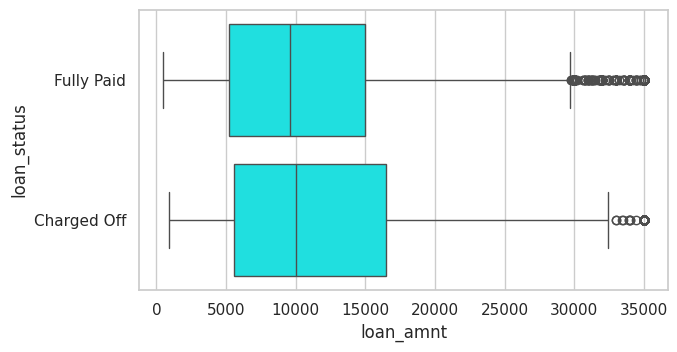

In [59]:
plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
sns.boxplot(y = 'loan_status', x = 'loan_amnt', data = data)
plt.show()

In [60]:
data['loan_amnt'].describe()

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [61]:
# Since there is a significant difference between the mean and median, let's limit our data to the top 75%.
loan_till75 = data.loc[(data['loan_amnt']<=15000)]

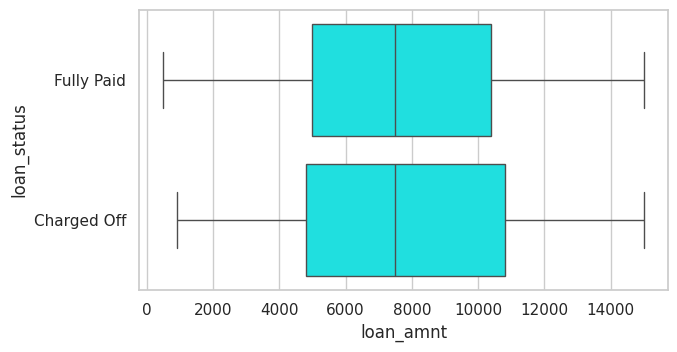

In [62]:
plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
sns.boxplot(x = 'loan_amnt',  y= 'loan_status', data = loan_till75)
plt.show()

In [63]:
# since it is giving picture , let us take date data above 75%
loan_above75 = data.loc[(data['loan_amnt']>=15000)]
loan_above75.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m,couting_days_from_earliest_cr_line,loan_status_numbers
20,20250,20250,19142.16108,60,15.27,484.63,C,C4,Archdiocese of Galveston Houston,3 years,...,8,0,17813,85.6,22,0.0,2011,12,9698,0
21,21000,21000,21000.00000,36,12.42,701.73,B,B4,Osram Sylvania,10+ years,...,7,0,32135,90.3,38,0.0,2011,12,15085,1
25,15000,15000,15000.00000,36,9.91,483.38,B,B1,Winfield Pathology Consultants,2 years,...,8,0,13707,93.9,31,0.0,2011,12,8145,0
26,15000,15000,8725.00000,36,14.27,514.64,C,C2,nyc transit,9 years,...,7,0,5872,57.6,11,0.0,2011,12,7538,1
31,31825,31825,31825.00000,36,7.90,995.82,A,A4,Audubon Mutual Housing Corporation,5 years,...,12,0,23151,27.4,26,0.0,2011,12,15542,0


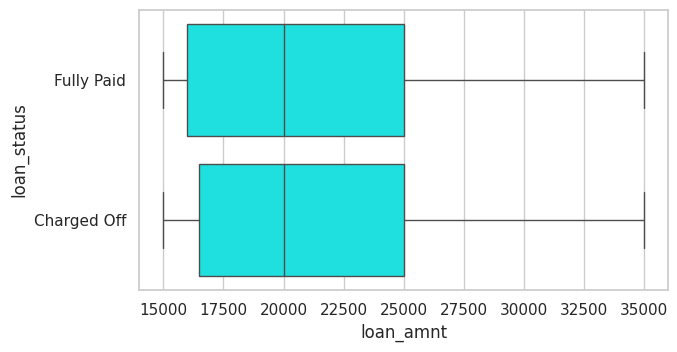

In [64]:
plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
sns.boxplot(y = 'loan_status', x = 'loan_amnt', data = loan_above75)
plt.show()

### From the above box plot, we can conclude that "higher amounts" tend to be "written off."

#### Since we have too many columns for univariate analysis, let's define some default functions that we can reuse for analyzing all the columns.

In [65]:
def percent_reduce(*, data=data, col, trailer=''):
    """
        Parameters:
            data : defaulted to 'loan'
            column : this is the continuous numeric field which has to be binned to its percentiles
            trailer : defaulted to blank, this will be added to the end of the percentile values
                      like '%' for interest rate related fields
        Returns:
            None
            It creates a new column in the data with a suffix '_p' and this contains the newly created category
    """
    new_col = col + '_p'
    labels = ['Lowest ','Lower ','Medium ','Higher ','Highest ']
    labels = [labels[p] + '(' +
              str(round(np.nanpercentile(data[col], p * 20),2)) +
              trailer + ' - ' +
              str(round(np.nanpercentile(data[col], (p+1) * 20),2)) +
              trailer + ')'
              for p in range(5)]
    data[new_col] = pd.qcut(data[col], q=5, labels=labels)

In [66]:
data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'pub_rec_bankruptcies', 'issue_y', 'issue_m',
       'couting_days_from_earliest_cr_line', 'loan_status_numbers'],
      dtype='object')

In [67]:
def univariate_analysis_cat(*, data=data, col, title=None, figsize=(8,6), grp_comparison=True, box_plot=False,
                            pct_comparison=False, filter=None, disp_filter = None):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            column : need to provide the numerical column for comparison
            figsize : a default have is given, but can be overridden
            loan_status_pct : a global variable, which is referred here for the percentage comparison
            grp_comparison : with this as true, it groups the data based on the categories and compares
            pct_comparison : this will call the Pct_Comparison method and below couple parameters will be applicable for it
            filter : any conditions based on which the data will be filtered before plotting, ignored if None
            disp_filter : string for display purpose only, valid if filter is not None
        Returns:
            None, does a countplot and a box plot as well, if needed
    """
    plotdata = data if filter is None else data.loc[filter]

    if pct_comparison and filter is not None:
        Pct_Comparison(filter, disp_filter)

    if grp_comparison:
        fig, ax = plt.subplots(figsize=figsize)
        sns.countplot(data=plotdata, y=col, hue=by, ax=ax,
                      order=plotdata[col].value_counts().index, hue_order=order)
        if title is not None:
            plt.title(title)
        plt.show()

        df = data.groupby([col])[by].value_counts(normalize=True
                                                    ).rename('Charged off %').reset_index().sort_values(col)
        df = df.loc[df[by]=='Charged Off'].sort_values(by='Charged off %', ascending=False).drop(columns=[by])
        df2 = data.groupby([col])[by].count()
        df = df.merge(right=df2,on=col).rename(columns={by:'Record count'})
        display(HTML(df.to_html(index=False)))

        if box_plot:
            df2.plot(kind='box',logy=True,x="No. of records of defaulted loans per category")
            plt.show()

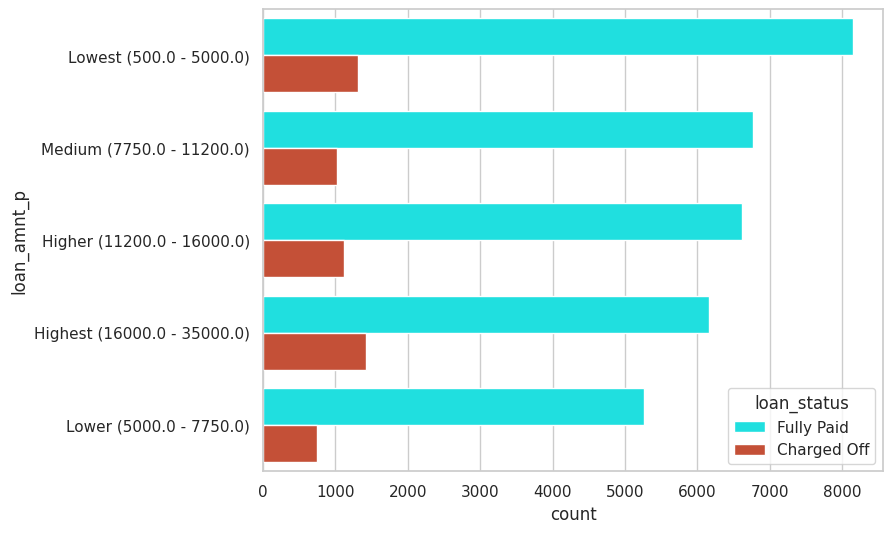

loan_amnt_p,Charged off %,Record count
Highest (16000.0 - 35000.0),0.187624,7579
Higher (11200.0 - 16000.0),0.145368,7739
Lowest (500.0 - 5000.0),0.138725,9472
Medium (7750.0 - 11200.0),0.131613,7788
Lower (5000.0 - 7750.0),0.123521,5999


In [68]:
percent_reduce(col='loan_amnt')
univariate_analysis_cat(col='loan_amnt_p')

#### The probability of a loan defaulting increases with the loan amount.

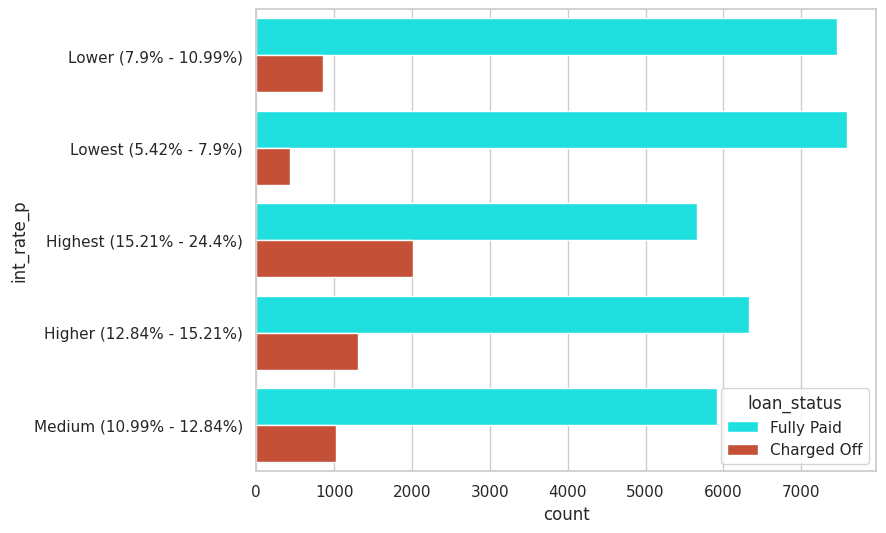

int_rate_p,Charged off %,Record count
Highest (15.21% - 24.4%),0.262150,7675
Higher (12.84% - 15.21%),0.171619,7639
Medium (10.99% - 12.84%),0.146995,6939
Lower (7.9% - 10.99%),0.102876,8311
Lowest (5.42% - 7.9%),0.053538,8013


In [69]:
percent_reduce(col='int_rate', trailer='%')
univariate_analysis_cat(col='int_rate_p')

#### An increase in the interest rate correlates with a higher percentage of charged-off loans.

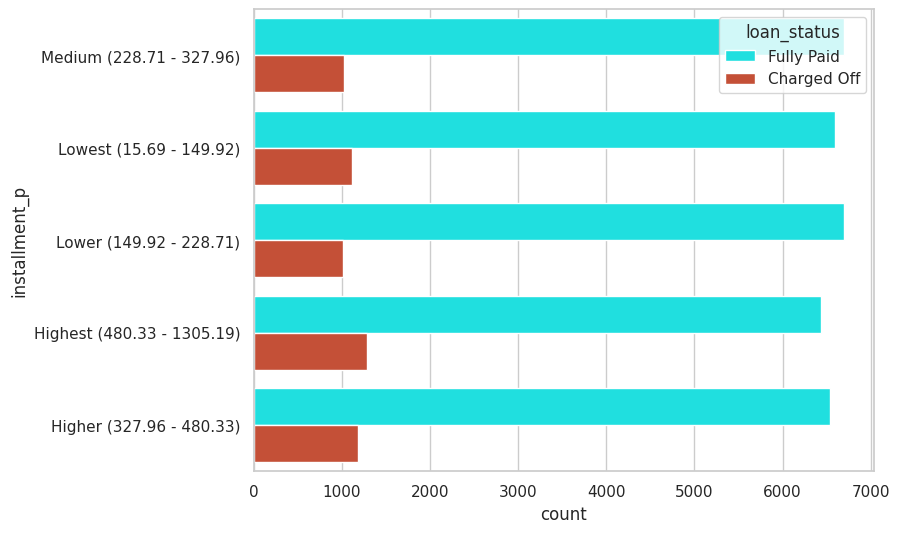

installment_p,Charged off %,Record count
Highest (480.33 - 1305.19),0.166321,7714
Higher (327.96 - 480.33),0.152988,7713
Lowest (15.69 - 149.92),0.145153,7716
Medium (228.71 - 327.96),0.132936,7718
Lower (149.92 - 228.71),0.131934,7716


In [70]:
percent_reduce(col='installment')
univariate_analysis_cat(col='installment_p')

Above data and plot shows that higher installment amounts shows higher default percentages.

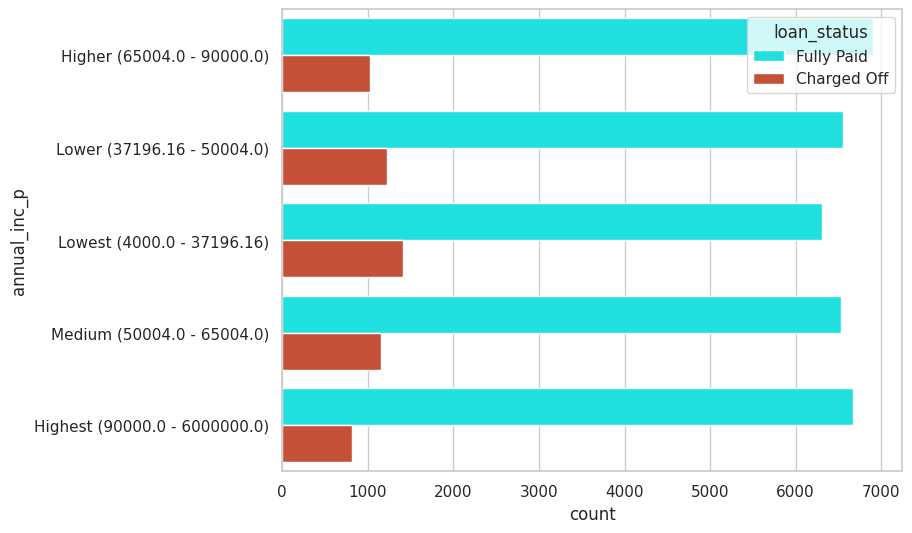

annual_inc_p,Charged off %,Record count
Lowest (4000.0 - 37196.16),0.183126,7716
Lower (37196.16 - 50004.0),0.156926,7768
Medium (50004.0 - 65004.0),0.149629,7679
Higher (65004.0 - 90000.0),0.129651,7929
Highest (90000.0 - 6000000.0),0.109285,7485


In [71]:
percent_reduce(col='annual_inc')
univariate_analysis_cat(col='annual_inc_p')

Higher the income hiegher the repayment %

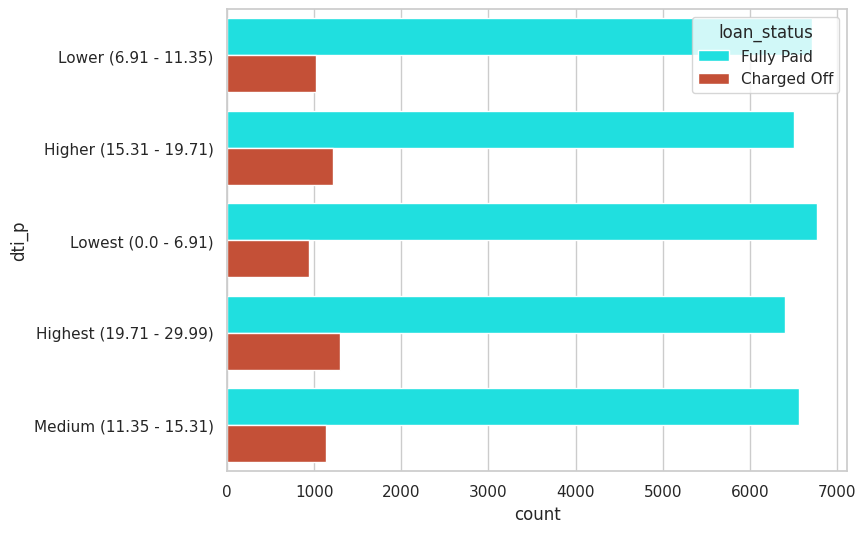

dti_p,Charged off %,Record count
Highest (19.71 - 29.99),0.168853,7699
Higher (15.31 - 19.71),0.157908,7726
Medium (11.35 - 15.31),0.147609,7696
Lower (6.91 - 11.35),0.132627,7736
Lowest (0.0 - 6.91),0.122409,7720


In [72]:
percent_reduce(col='dti')
univariate_analysis_cat(col='dti_p')

#### higher DTI ( debt to income ratio) will lead to higher charged off %

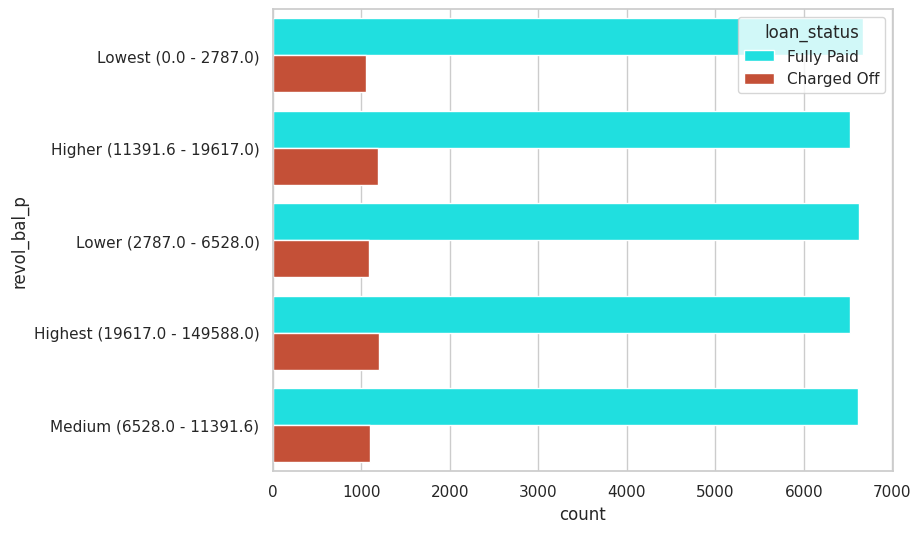

revol_bal_p,Charged off %,Record count
Highest (19617.0 - 149588.0),0.154913,7714
Higher (11391.6 - 19617.0),0.154335,7717
Medium (6528.0 - 11391.6),0.142894,7712
Lower (2787.0 - 6528.0),0.141283,7715
Lowest (0.0 - 2787.0),0.135898,7719


In [73]:
percent_reduce(col='revol_bal')
univariate_analysis_cat(col='revol_bal_p')

#### This shows the total credit revolving balances slightly influence the default percentage. Higher the revolving balance, bigger the chance of the loan getting defaulted.

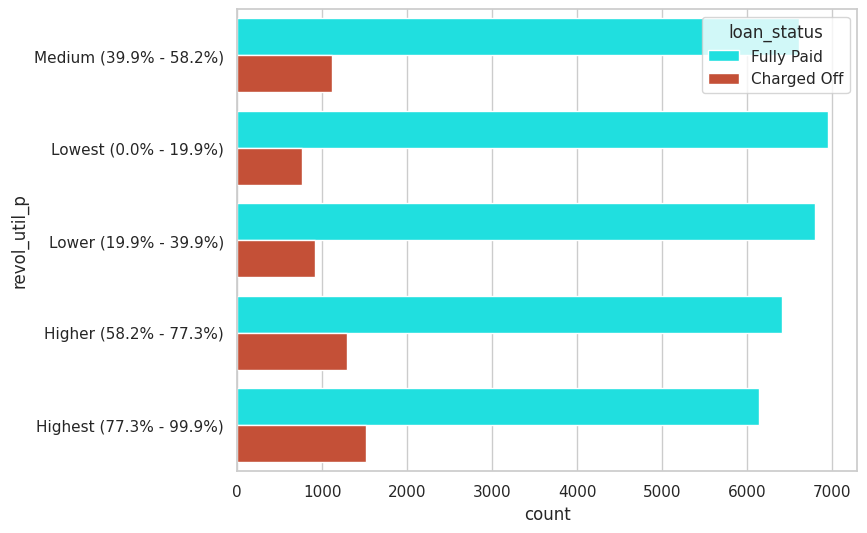

revol_util_p,Charged off %,Record count
Highest (77.3% - 99.9%),0.198069,7664
Higher (58.2% - 77.3%),0.167727,7703
Medium (39.9% - 58.2%),0.145001,7731
Lower (19.9% - 39.9%),0.118356,7714
Lowest (0.0% - 19.9%),0.099417,7715


In [74]:
percent_reduce(col='revol_util',trailer='%')
univariate_analysis_cat(col='revol_util_p')

#### This data demonstrates a significant correlation between the revolving line utilization rate and the default percentage; as the utilization rate increases, so does the charged-off percentage.

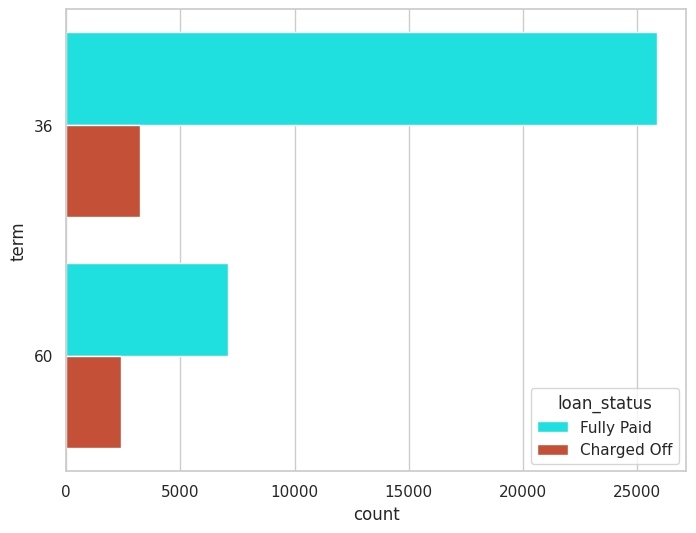

term,Charged off %,Record count
60,0.253138,9481
36,0.110909,29096


In [75]:
univariate_analysis_cat(col='term')

For loans with 5 year repayment term, the default percent is 25%. And for 3 year loan repayment term, the default is only for 11% of the cases.
Therefore, loan repayment term plays a factor in judging the default rate.

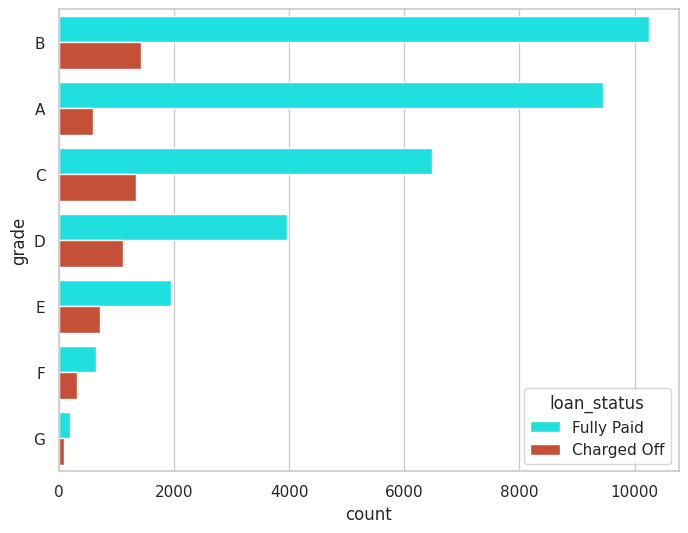

grade,Charged off %,Record count
G,0.337793,299
F,0.326844,976
E,0.268494,2663
D,0.219862,5085
C,0.171943,7834
B,0.122056,11675
A,0.059930,10045


In [76]:
univariate_analysis_cat(col='grade')

We can clearly see that loan grades having highest default percentages. G, F, E and D form grades where default rate is much higher than others.


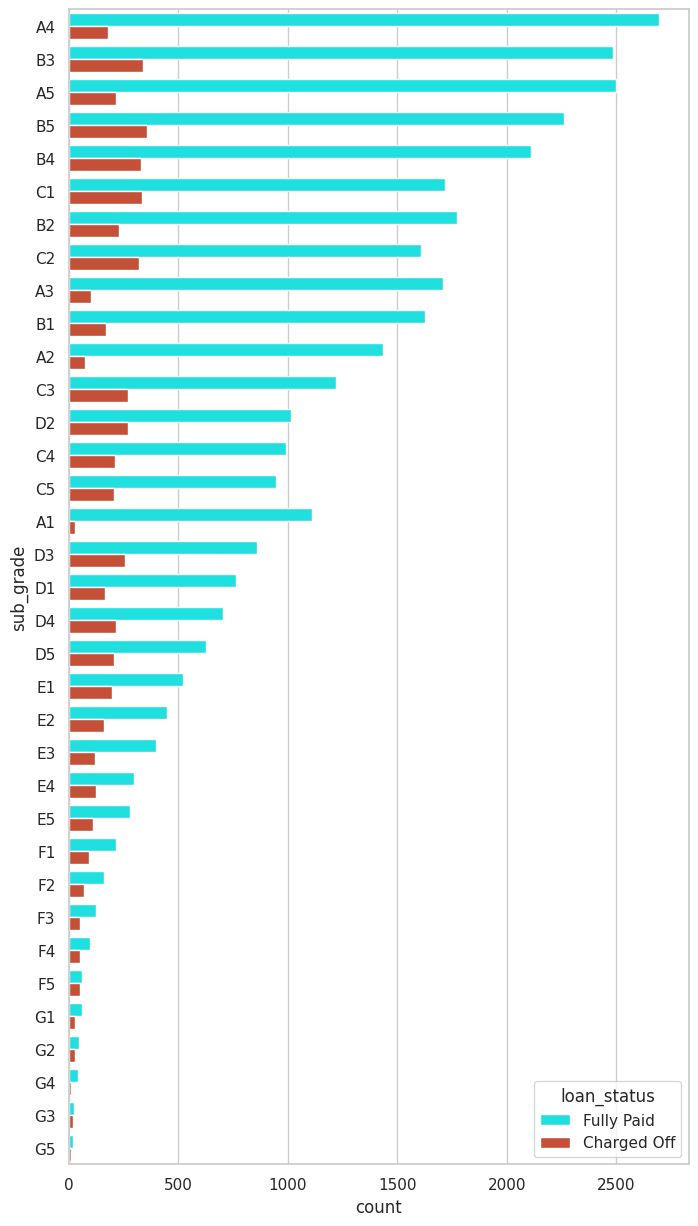

sub_grade,Charged off %,Record count
F5,0.477876,113
G3,0.422222,45
G2,0.363636,77
F4,0.350993,151
G5,0.344828,29
G1,0.329787,94
F2,0.300429,233
F1,0.298361,305
E4,0.297170,424
F3,0.293103,174


In [77]:
univariate_analysis_cat(col='sub_grade', figsize=(8,15))

#### The table above illustrates the relationship between loan sub-grade and default percentage. Sub-categories G3 and F5 exhibit default rates exceeding 40%, making this field a robust indicator of default likelihood.

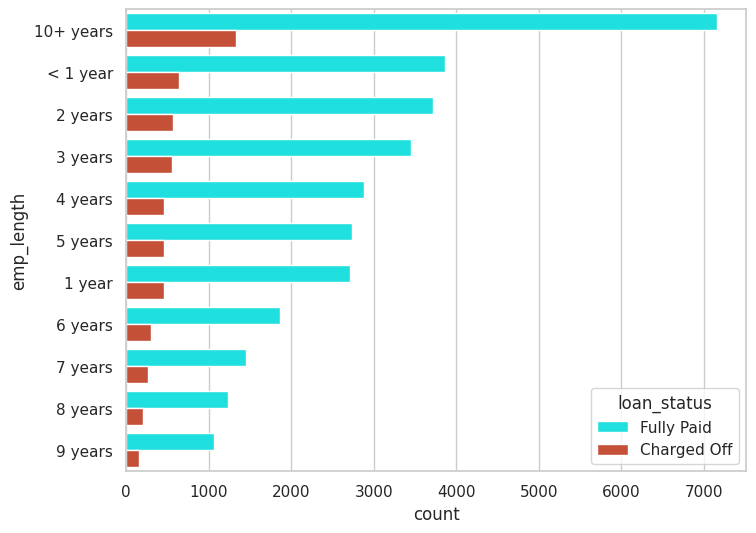

emp_length,Charged off %,Record count
10+ years,0.156810,8488
7 years,0.153711,1711
1 year,0.143894,3169
5 years,0.143394,3194
< 1 year,0.141748,4508
6 years,0.141605,2168
8 years,0.141463,1435
3 years,0.138335,4012
4 years,0.138241,3342
2 years,0.132137,4291


In [78]:
univariate_analysis_cat(col='emp_length')

although there is nothing much to conclude from above data, we can see having no employment will lead to Defaulted payment

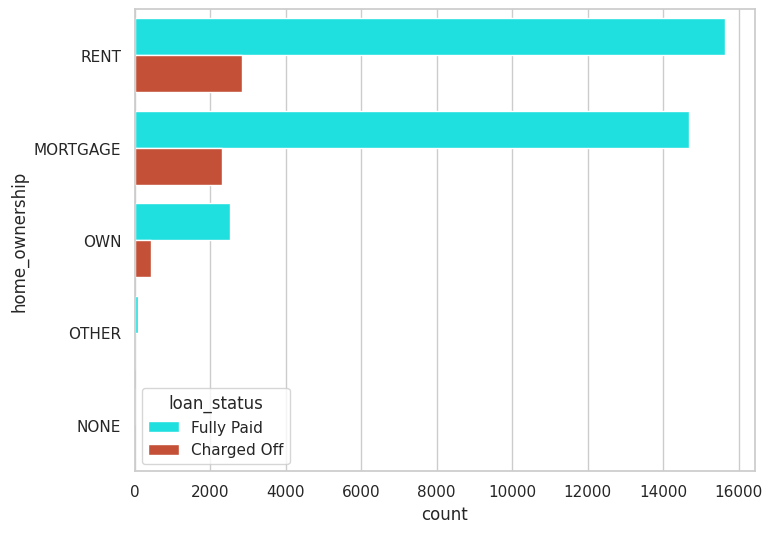

home_ownership,Charged off %,Record count
OTHER,0.183673,98
RENT,0.153626,18480
OWN,0.148908,2975
MORTGAGE,0.136713,17021


In [79]:
univariate_analysis_cat(col='home_ownership')

we have not much info to conclude as it says "OTHER",

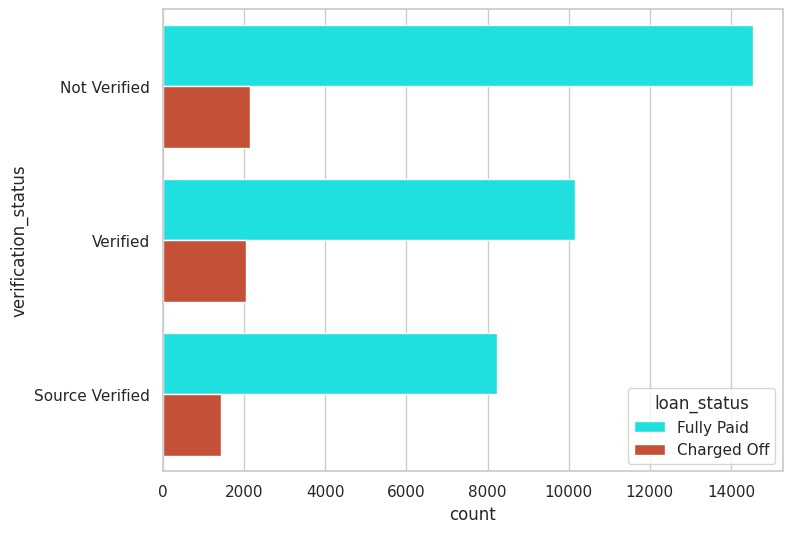

verification_status,Charged off %,Record count
Verified,0.168032,12206
Source Verified,0.148186,9677
Not Verified,0.128310,16694


In [80]:
univariate_analysis_cat(col='verification_status')

interestingly verified applicants have more defaulted % which means the verifiaction process is not correct.

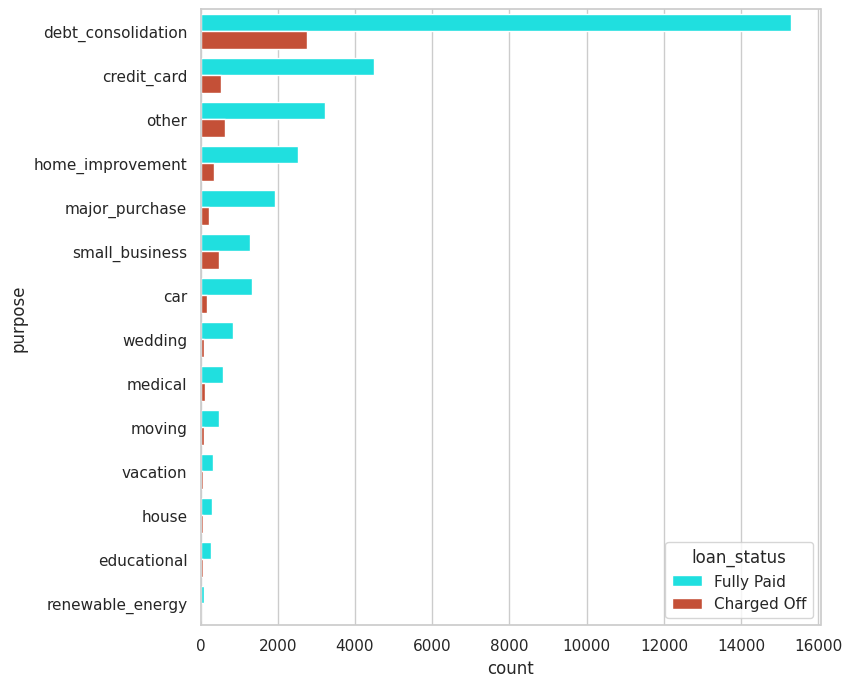

purpose,Charged off %,Record count
small_business,0.270810,1754
renewable_energy,0.186275,102
educational,0.172308,325
other,0.163777,3865
house,0.160763,367
moving,0.159722,576
medical,0.155653,681
debt_consolidation,0.153254,18055
vacation,0.141333,375
home_improvement,0.120696,2875


In [82]:
univariate_analysis_cat(col='purpose', figsize=(8,8))

From the above analysis it is evidend that the loans taken for small_business, renewable_energy and educational are the riskier ones.

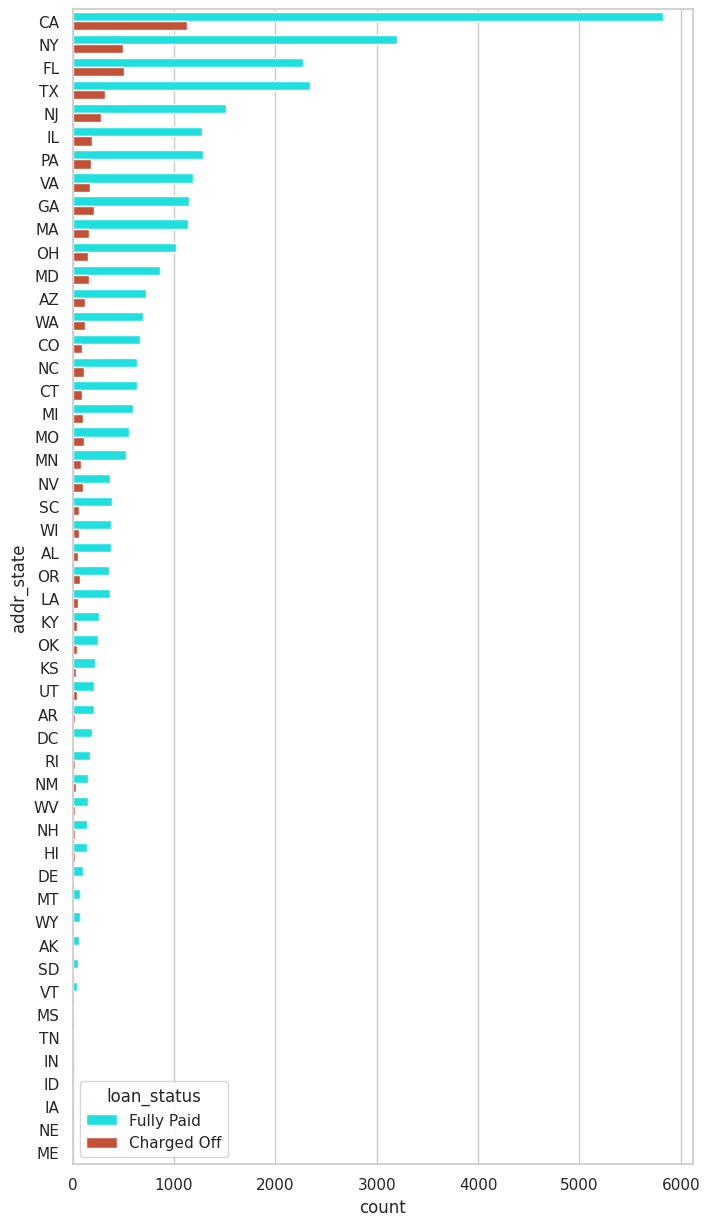

addr_state,Charged off %,Record count
NE,0.600000,5
NV,0.225470,479
SD,0.193548,62
AK,0.192308,78
FL,0.181230,2781
MO,0.170149,670
HI,0.168675,166
ID,0.166667,6
NM,0.163934,183
OR,0.163218,435


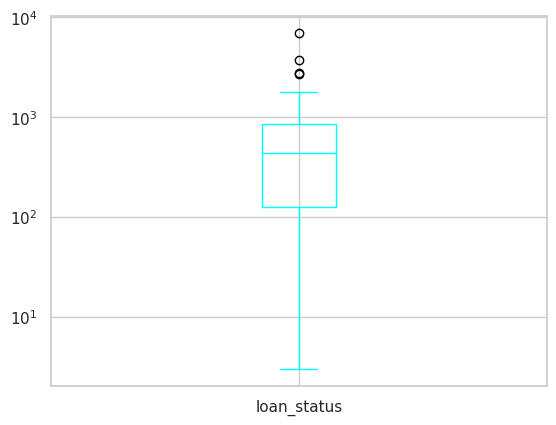

In [83]:
univariate_analysis_cat(col='addr_state',figsize=(8,15), box_plot=True)

From the above table we can see that the some of the risky states are NE, NV, SD, AK, FL, MO

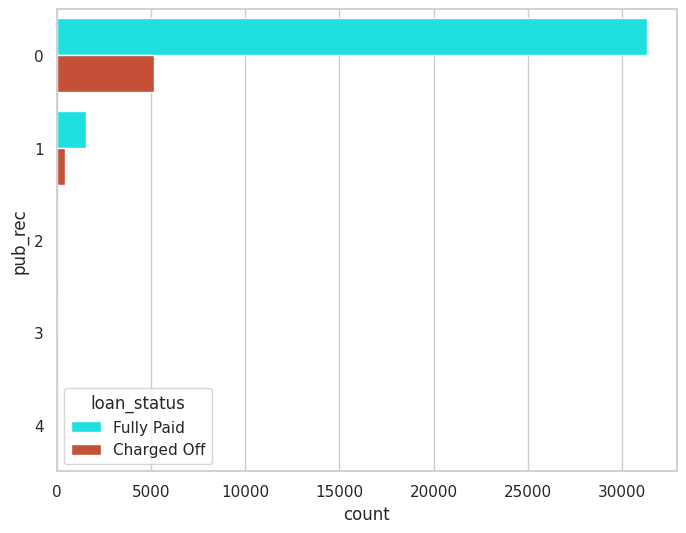

pub_rec,Charged off %,Record count
1,0.227024,2013
2,0.208333,48
0,0.141343,36507


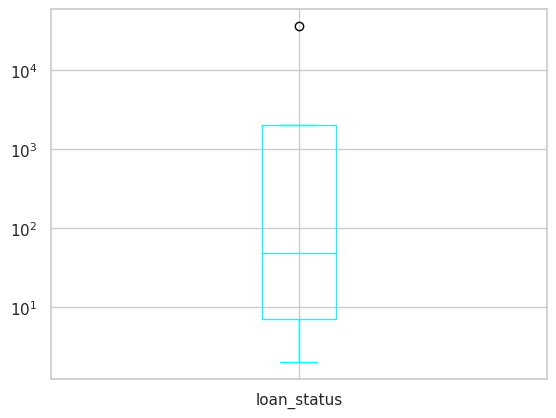

In [85]:
univariate_analysis_cat(col='pub_rec', box_plot=True)

Above data and graph crealy shows that individuals with non-zero derogatory public records have higher chances of charged off

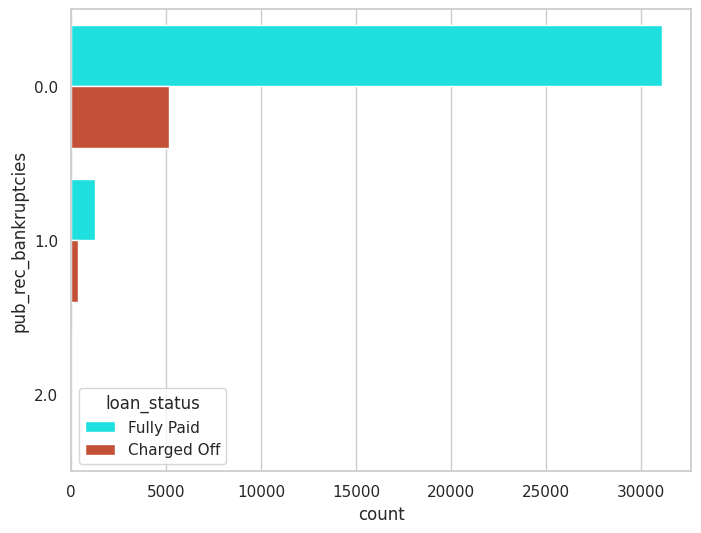

pub_rec_bankruptcies,Charged off %,Record count
2.0,0.400000,5
1.0,0.223580,1637
0.0,0.141868,36238


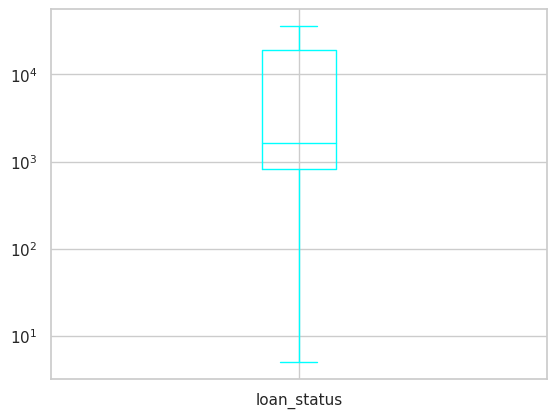

In [86]:
univariate_analysis_cat(col='pub_rec_bankruptcies', box_plot=True)

Higher the number of public bankruptcy records, bigger the chance of defaulting the loan.

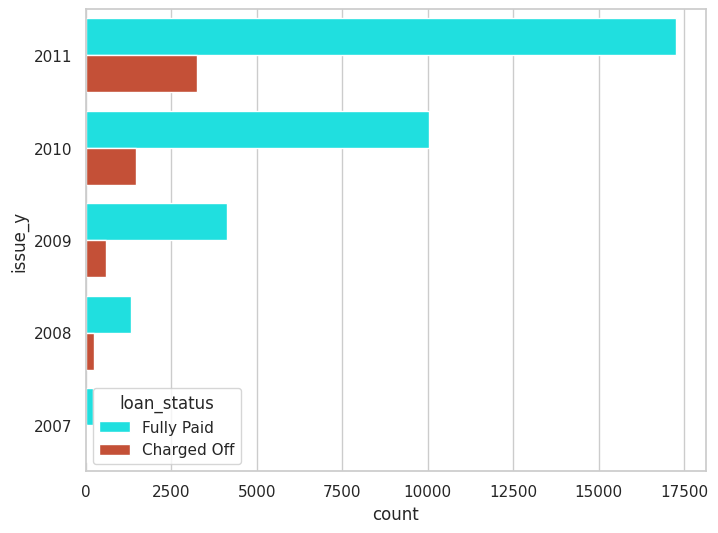

issue_y,Charged off %,Record count
2007,0.179283,251
2011,0.158705,20516
2008,0.158131,1562
2010,0.128772,11532
2009,0.125954,4716


In [87]:
univariate_analysis_cat(col='issue_y')

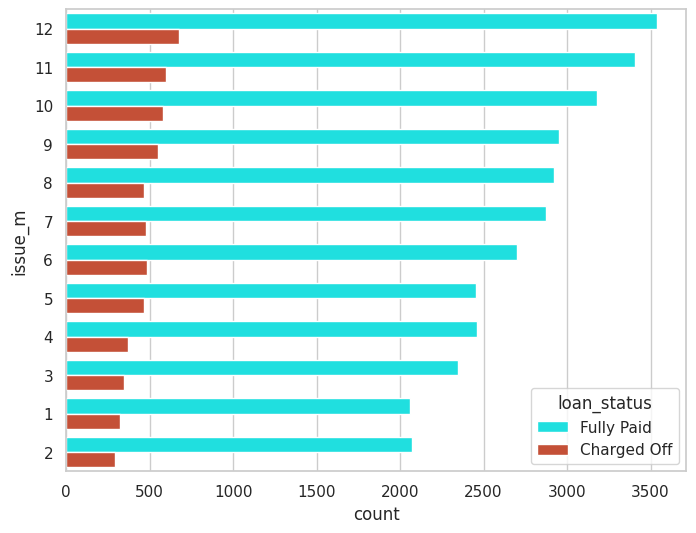

issue_m,Charged off %,Record count
12,0.160854,4215
5,0.159644,2919
9,0.156375,3498
10,0.154214,3761
6,0.151887,3180
11,0.149276,4006
7,0.142942,3351
8,0.138135,3388
1,0.134931,2379
4,0.130696,2831


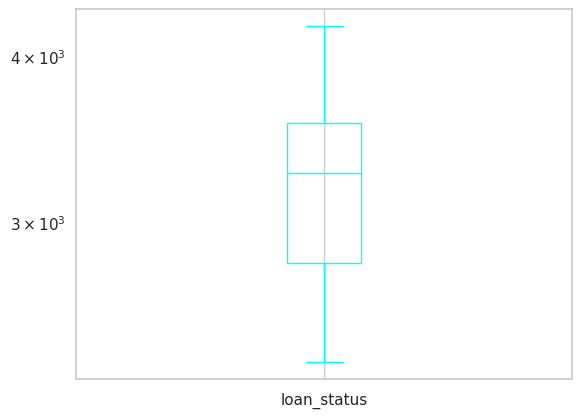

In [88]:
univariate_analysis_cat(col='issue_m', box_plot=True)

- December consistently records the highest number of loan applications annually and has the highest default ratio.
  - This trend may be attributed to loans taken for travel and celebrations during the Christmas season, leading to repayment difficulties.
- May is another peak period for loan applications and defaults.
  - This timing coincides with the summer break and major holidays such as Memorial Day and Independence Day in the US, when travel is common.

# Bivariate Analysis

- After analyzing the impact of each variable on loan status individually, we will now examine the combined effect of grouped variables.
- These groups are categorized based on our business understanding.
- The "Original Distribution" column reflects the average trend across all data.
- We will compare this average trend with the data after applying our specified conditions to assess the combined impact on loan status.


In [90]:
def bivariate_analysis(*, data=data, x, y, title=None):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, one numerical and one categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a violin plot
    """
    fig, ax = plt.subplots()
    sns.violinplot(data=data, x=x, y=y, hue=by, split=True,
                   ax=ax, hue_order=order)
    if title is not None:
        plt.title(title)
    plt.show()

In [ ]:
def bivariate_analysis_cat(*, data=data, x, y, title=None):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, both categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a heatmap plot
    """
    fig, ax = plt.subplots()
    pt = pd.pivot_table(data=data, values='loan_status_num', index=y, columns=x)
    sns.heatmap(pt, ax=ax, cmap='YlGnBu')
    if title is not None:
        plt.title(title)
    plt.show()

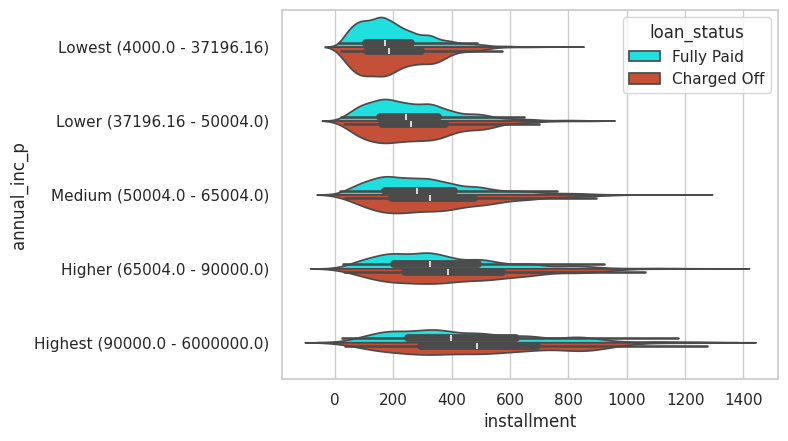

In [91]:
bivariate_analysis(x='installment', y='annual_inc_p')
plt.show()

Above figure shows that for higher installments for any income group have more number of defaults.

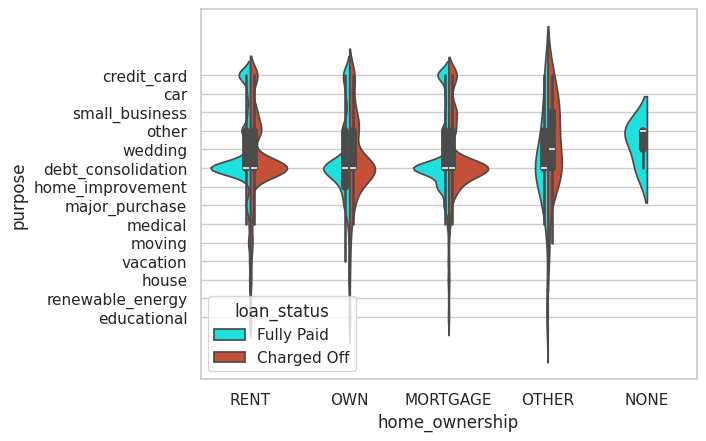

In [93]:
bivariate_analysis_cat(x='home_ownership', y='purpose')

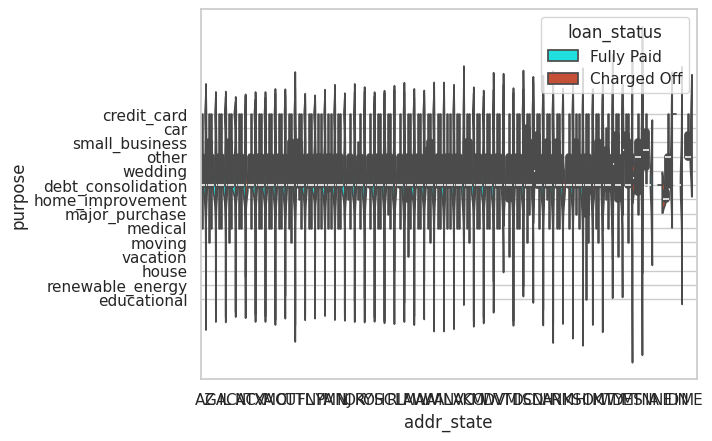

In [94]:
bivariate_analysis_cat(x='addr_state', y='purpose')

- Based on the plot analysis, states with darker shading at the intersection with loan purposes indicate higher risk for loan applications.
- Examples include:
  - Vacation loans in AK, HI, OR
  - Education loans in AR, KS, UT
  - Small business loans in DE, NM, WV, WY
  - Wedding loans in MS, OR

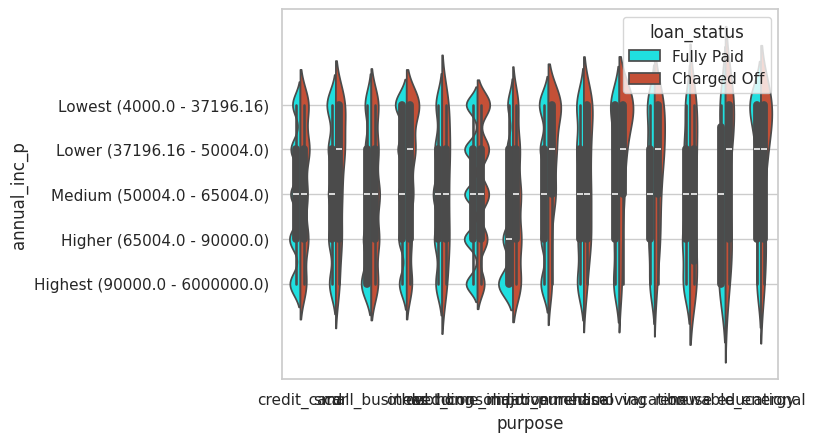

In [95]:
bivariate_analysis_cat(x='purpose', y='annual_inc_p')

- The plot depicts the correlation between income groups and the risk profile associated with different loan purposes.
- Examples observed include:
  - Small business loans being riskier for the lowest and medium income groups.
  - Renewable energy loans showing higher risk among the higher income group.


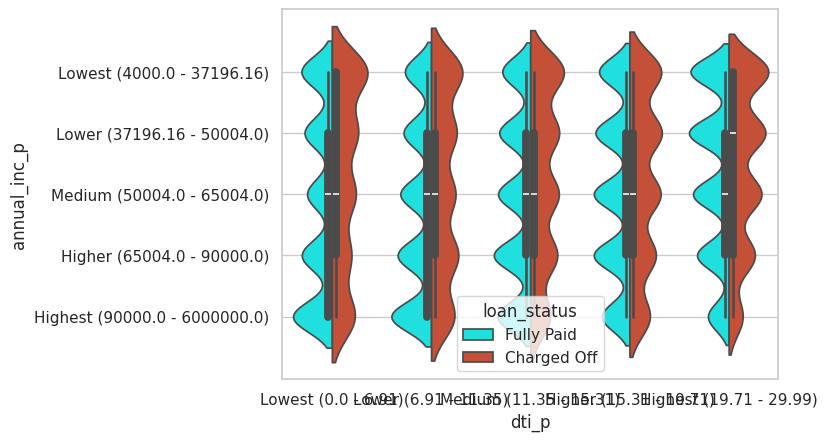

In [96]:
bivariate_analysis_cat(x='dti_p', y='annual_inc_p')

Medium debt-to-income group in the lowest income range is the most risky when it comes to loan repayment.

Certainly! Here's a more formal presentation of the key findings from the exploratory data analysis (EDA) of the loan dataset, categorizing factors by their impact on loan default:

**Factors with Minor Impact**
- Higher loan amount (above $16,000)

- Higher installment amount (above $327)

- Lower annual income (below $37,000)

- Higher debt-to-income ratio (above 15%)

- Applicant’s address state (e.g., NV, SD, AK, FL)

- Loan issue month (Dec, May, Sep)

**Factors with Heavy Impact**
- Higher interest rate (above 13%)
- Higher revolving line utilization rate (above 58%)
- Repayment term of 5 years
- Loan grade & sub-grade (D to G)
- Missing employment record
- Loan purpose (small business, renewable energy, educational)
- Derogatory public records (1 or 2)
- Public bankruptcy records (1 or 2)

**Factors with Combined Impact**
- High loan amount & interest rate for lower income group
- High installment and longer repayment term
- Home ownership (other) and loan purpose (car, moving, or small business)
- Residential state and loan purpose
- Income group and loan purpose

This EDA identifies these factors as the most impactful drivers for loan default, providing valuable insights into risk assessment and decision-making processes within the lending industry.